In [1]:
import h5py
import torch
import numpy as np

# Build a neural net that takes in 1024 dim vectors and outputs 1024 dim vectors
import torch.nn as nn
import torch.nn.functional as F


class EmbeddingMapper(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1024, hidden_dim=256):  # Reduced from 512
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.final = nn.Linear(128, output_dim)
        # self.dropout = nn.Dropout(0.5)

        # nn.init.xavier_uniform_(self.fc3.weight, gain=0.1)
        # nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.final(x)

        x = F.normalize(x, p=2, dim=1)
        return x


device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model = EmbeddingMapper(input_dim=1024, output_dim=1024).to(device)

# L1 regularization
# L1_lambda = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

loss_function = nn.TripletMarginWithDistanceLoss(
    margin=0.2,
    distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y),
)

In [2]:
from torch.utils.data import DataLoader, Dataset


# --- Example dataset ---
class TripletDataset(Dataset):
    def __init__(self, h5_path: str):
        with h5py.File(h5_path, "r") as f:
            self.triplets = torch.from_numpy(f["triplets"][:]).float()

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor = self.triplets[idx, 0, :]
        positive = self.triplets[idx, 1, :]
        negative = self.triplets[idx, 2, :]
        return anchor, positive, negative


train_dataset = TripletDataset("../src/citeline/nn/np_vectors_train_triplets.h5")
val_dataset = TripletDataset("../src/citeline/nn/np_vectors_val_triplets.h5")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 52668
Validation dataset size: 11088


In [3]:
# What's the average cosine distance between positives and negatives?
distances = [1 - F.cosine_similarity(pos.unsqueeze(0), neg.unsqueeze(0)).item() for _, pos, neg in train_dataset]
print(f"Average cosine distance between positives and negatives: {np.mean(distances):.4f}")
print(f"Stddev of cosine distance between positives and negatives: {np.std(distances):.4f}")

Average cosine distance between positives and negatives: 0.3889
Stddev of cosine distance between positives and negatives: 0.1041


In [4]:
# Check initial similarities in the raw data
ap_distances = []
an_distances = []
for anchor, pos, neg in train_dataset:
    ap_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), pos.unsqueeze(0)).item()
    an_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), neg.unsqueeze(0)).item()
    ap_distances.append(ap_dist)
    an_distances.append(an_dist)

print(f"Average Anchor-Positive distance: {np.mean(ap_distances):.4f} ± {np.std(ap_distances):.4f}")
print(f"Average Anchor-Negative distance: {np.mean(an_distances):.4f} ± {np.std(an_distances):.4f}")
print(f"Average margin in raw data: {np.mean(an_distances) - np.mean(ap_distances):.4f}")
print(f"\nInterpretation:")
print(f"- If margin > 0: negatives are already farther from anchors than positives (good!)")
print(f"- If margin ≈ 0: anchors are equidistant to positives and negatives (hard problem!)")
print(f"- If margin < 0: negatives are CLOSER to anchors than positives (data issue!)")

Average Anchor-Positive distance: 0.3814 ± 0.1005
Average Anchor-Negative distance: 0.3269 ± 0.0612
Average margin in raw data: -0.0544

Interpretation:
- If margin > 0: negatives are already farther from anchors than positives (good!)
- If margin ≈ 0: anchors are equidistant to positives and negatives (hard problem!)
- If margin < 0: negatives are CLOSER to anchors than positives (data issue!)


In [5]:
# Baseline loss
with torch.no_grad():
    model.eval()
    val_losses = []
    for anchors, positives, negatives in val_dataloader:
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        anchor_out = model(anchors)
        val_loss = loss_function(anchor_out, positives, negatives)
        val_losses.append(val_loss.item())
baseline_val_loss = np.mean(val_losses)
print(f"Baseline validation loss (no training): {baseline_val_loss:.4f}")
# Check if the model is mapping anchors closer to positives
model.eval()
for name, dataset in [("Validation", val_dataset)]:
    ap_distances_after = []
    an_distances_after = []

    with torch.no_grad():
        for anchor, pos, neg in list(dataset)[:1000]:
            anchor = anchor.to(device).unsqueeze(0)

            anchor_emb = model(anchor)  # Only transform anchor

            # Compare to raw positive/negative (no transformation)
            ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
            an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

            ap_distances_after.append(ap_dist)
            an_distances_after.append(an_dist)

    print(f"=== BEFORE TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
    print(f"Anchor-Positive distance: {np.mean(ap_distances_after):.4f}")
    print(f"Anchor-Negative distance: {np.mean(an_distances_after):.4f}")
    print(f"Learned margin: {np.mean(an_distances_after) - np.mean(ap_distances_after):.4f}")

Baseline validation loss (no training): 0.2008
=== BEFORE TRAINING (Validation set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 1.0327
Anchor-Negative distance: 1.0324
Learned margin: -0.0003


In [6]:
train_loss_history = []
val_loss_history = []
pos_dist_weight = 0.1
NUM_EPOCHS = 15
min_val_loss = float("inf")
for epoch in range(NUM_EPOCHS):
    # ---- Training ----
    model.train()
    train_losses = []
    for batch_idx, (anchors, positives, negatives) in enumerate(train_dataloader):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        optimizer.zero_grad()
        anchor_out = model(anchors)

        loss = loss_function(anchor_out, positives, negatives)
        # L1 + loss
        # L1_loss = sum(torch.linalg.norm(param, 1) for param in model.parameters())
        # loss = loss_function(anchor_out, positive_out, negative_out) + L1_loss * L1_lambda

        # ---- Add distance-to-positive penalty ----
        # dist = 1.0 - F.cosine_similarity(anchor_out, positives)
        # loss = loss + pos_dist_weight * dist.mean()

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss_epoch = np.mean(train_losses)
    train_loss_history.append(train_loss_epoch)

    # ---- Validation ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for anchors, positives, negatives in val_dataloader:
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            anchor_out = model(anchors)
            val_loss = loss_function(anchor_out, positives, negatives)
            val_losses.append(val_loss.item())

    val_loss_epoch = np.mean(val_losses)
    val_loss_history.append(val_loss_epoch)
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        # Save the best model
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch}: Train Loss = {train_loss_epoch:.4f}, Val Loss = {val_loss_epoch:.4f}")

Epoch 0: Train Loss = 0.1840, Val Loss = 0.1798
Epoch 1: Train Loss = 0.1498, Val Loss = 0.1699
Epoch 2: Train Loss = 0.1286, Val Loss = 0.1670
Epoch 3: Train Loss = 0.1161, Val Loss = 0.1654
Epoch 4: Train Loss = 0.1067, Val Loss = 0.1648
Epoch 5: Train Loss = 0.0990, Val Loss = 0.1647
Epoch 6: Train Loss = 0.0924, Val Loss = 0.1641
Epoch 7: Train Loss = 0.0868, Val Loss = 0.1637
Epoch 8: Train Loss = 0.0819, Val Loss = 0.1646
Epoch 9: Train Loss = 0.0775, Val Loss = 0.1646
Epoch 10: Train Loss = 0.0736, Val Loss = 0.1638
Epoch 11: Train Loss = 0.0701, Val Loss = 0.1638
Epoch 12: Train Loss = 0.0668, Val Loss = 0.1640
Epoch 13: Train Loss = 0.0638, Val Loss = 0.1640
Epoch 14: Train Loss = 0.0611, Val Loss = 0.1635


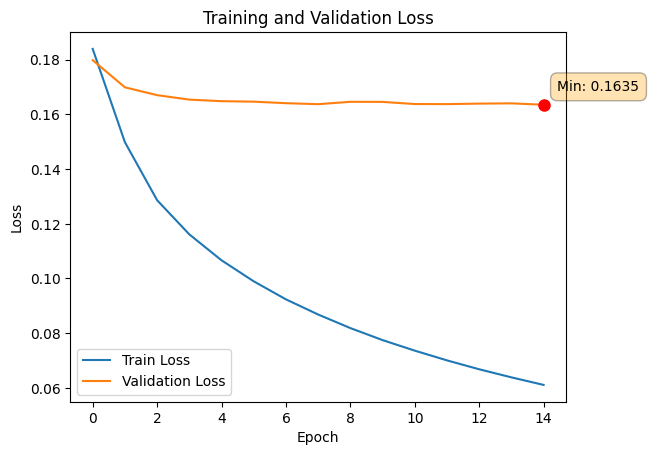

In [7]:
# Plot train and validation loss
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Add a notation where the minimal val loss occurred and amount
min_val_loss = min(val_loss_history)
min_val_loss_epoch = val_loss_history.index(min_val_loss)

# Mark the point
plt.plot(min_val_loss_epoch, min_val_loss, "ro", markersize=8)

# Add annotation with box
plt.annotate(
    f"Min: {min_val_loss:.4f}",
    xy=(min_val_loss_epoch, min_val_loss),
    xytext=(10, 10),  # Offset in points
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="orange", alpha=0.3),
    # arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
)

plt.title("Training and Validation Loss")
plt.show()

In [8]:
loss_reduction = 1 - (min_val_loss / baseline_val_loss)
print(f"Best loss reduction: {loss_reduction*100:.2f}%")

Best loss reduction: 18.55%


In [9]:
# Check if the model is mapping anchors closer to positives
model.eval()
for name, dataset in [("Validation", val_dataset)]:
    ap_distances_after = []
    an_distances_after = []

    with torch.no_grad():
        for anchor, pos, neg in list(dataset)[:1000]:
            anchor = anchor.to(device).unsqueeze(0)

            anchor_emb = model(anchor)  # Only transform anchor

            # Compare to raw positive/negative (no transformation)
            ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
            an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

            ap_distances_after.append(ap_dist)
            an_distances_after.append(an_dist)

    print(f"=== AFTER TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
    print(f"Anchor-Positive distance: {np.mean(ap_distances_after):.4f}")
    print(f"Anchor-Negative distance: {np.mean(an_distances_after):.4f}")
    print(f"Learned margin: {np.mean(an_distances_after) - np.mean(ap_distances_after):.4f}")

=== AFTER TRAINING (Validation set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 1.1030
Anchor-Negative distance: 1.1476
Learned margin: 0.0445


In [10]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test set
test_dataset = TripletDataset("../src/citeline/nn/np_vectors_test_triplets.h5")
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
model.eval()
test_losses = []
with torch.no_grad():
    for anchors, positives, negatives in test_dataloader:
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        anchor_out = model(anchors)
        test_loss = loss_function(anchor_out, positives, negatives)
        test_losses.append(test_loss.item())
mean_test_loss = np.mean(test_losses)
print(f"Mean test loss: {mean_test_loss:.4f}")
std_test_loss = np.std(test_losses)
print(f"Stddev of test loss: {std_test_loss:.4f}")

/var/folders/br/rmys_1r571qbwgg30gx_x2l40000gn/T/ipykernel_29008/2834268565.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.

Mean test loss: 0.1605
Stddev of test loss: 0.0284
